## import module

In [1]:
import numpy as np
from math import copysign
import matplotlib.pyplot as plt
from tqdm import tqdm
from missile_gym import MissileGym
import pickle

In [2]:
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]

## options

In [3]:
opts = {
    'm_0': 2350,
    'vel_abs': 1700,
    't_marsh': 12.8,
    'w_marsh': 1450,
    'P_marsh': 300e3,
    'dt': 0.05,
    'tau': 1/10,
    't_max': 165,
    'I': 2500,
    'r_kill': 50,
    'alpha_max': 20,
    'am': 5,
    'dny': 1,
    'init_conditions': {'V_0': 25, 'pos_0': (0, 20)},
    'd': 0.515,
    'L_korp': 8.298,
    'L_cil': 5.519,
    'L_korm': 0.135,
    'L_oper': 1.25,
    'L_kon1': 0.913,
    'L_kon2': 1.731,
    'b_0_oper': 1360 / 1e3,
    'x_b_oper': 7.37,
    'a': 0.2,
    'betta_kon2': 1,
    'd_korm': 0.490,
    'c_oper': 0.03,
    'khi_pk_oper': 55,
    'khi_rul': 0.0,
    'class_korp': 7,
    'class_oper': 5,
    'S_oper': 1.1,
    'x_ct_0': 4.808396444826858,
    'x_ct_marsh': 4.137372904870341,
}

## function

In [4]:
def mass_minimize(combination, mis_opts, trg_pos, trg_vel):
    
    thrust, t_act = combination
    
    omega = thrust * t_act / I_1
    mis_opts['m_0'] = omega + 750
    mis_opts['t_marsh'] = t_act
    mis_opts['w_marsh'] = omega
    mis_opts['P_marsh'] = thrust
    mis_opts['I'] = I_1

    gym = MissileGym.make_simple_scenario(mis_opts, trg_pos, trg_vel)
    
    vel_array = []
    done = False  
    while not done:
        obs, done, info = gym.step_with_guidance()
        state = gym.get_state()
        vel_array.append(float(gym.missile.get_summary()['v']))
        
    vel_abs = np.mean(vel_array)    
    inf = info['done_reason']
    mis_smry = gym.missile.get_summary()    
    etta = thrust / (mis_opts['m_0'] * 9.80665)
    
    # P, t_act, m_0, w, inf, etta, x, y, t, v_mean, v
    return np.array([thrust, 
                     t_act,
                     mis_opts['m_0'],
                     omega,
                     inf,
                     etta,
                     mis_smry['x'],
                     mis_smry['y'],
                     mis_smry['t'],
                     mis_smry['v'],
                     vel_abs])

In [5]:
thrusts = np.linspace(250e3, 310e3, 30)
ts_act = np.linspace(9, 15, 30)
I_1 = 2550
trg_pos = (200e3, 30e3)
trg_vel = (0, 0)

## variable options

In [ ]:
# через распараллеливание процесса на ядра
from joblib import Parallel, delayed

combinations = []
for i in range(len(thrusts)):
    for j in range(len(ts_act)):
        combination = thrusts[i], ts_act[j]
        combinations.append(combination)
        
out = Parallel(n_jobs=12, verbose=10)(delayed(mass_minimize)(combination, opts, trg_pos, trg_vel) for combination in combinations)

In [ ]:
with open('saves/mass_minimize.bin', 'wb') as f:
    pickle.dump(out, f)

In [ ]:
# перебор на одном ядре
variable = []
for i in tqdm(range(len(thrusts))):
    for j in range(len(ts_act)):
        combination = thrusts[i], ts_act[j]
        res = mass_minimize(combination, opts, trg_pos, trg_vel)
        print(res)
        res_hit.append(res)

In [ ]:
with open('saves/mass_minimize.bin', 'wb') as f:
    pickle.dump(res_hit, f)

## vizualizing

In [6]:
with open('saves/mass_minimize.bin', 'rb') as f:
    res_hit = pickle.load(f)

In [10]:
mass_max = 2100
vel_min = 1500
etta_max = 14
l_gr_max = 3.5

arr1_thrust = []
arr1_t_act = []
arr2_thrust = []
arr2_t_act = []
arr3_thrust = []
arr3_t_act = []
arr4_thrust = []
arr4_t_act = []
arr5_thrust = []
arr5_t_act = []
arr5_w = []

for i in range(len(res_hit)):
    
    l_gr = float(res_hit[i][3]) / (1850 * np.pi * (0.520**2) / 4) 
    
    if l_gr > l_gr_max:
        arr1_thrust.append(float(res_hit[i][0]))
        arr1_t_act.append(float(res_hit[i][1]))
    elif float(res_hit[i][2]) > mass_max:
        arr2_thrust.append(float(res_hit[i][0]))
        arr2_t_act.append(float(res_hit[i][1]))
    elif float(res_hit[i][5]) > etta_max:
        arr3_thrust.append(float(res_hit[i][0]))
        arr3_t_act.append(float(res_hit[i][1]))
    elif float(res_hit[i][-1]) < vel_min:
        arr4_thrust.append(float(res_hit[i][0]))
        arr4_t_act.append(float(res_hit[i][1]))
    else:
        arr5_thrust.append(float(res_hit[i][0]))
        arr5_t_act.append(float(res_hit[i][1]))
        arr5_w.append(float(res_hit[i][3]))

In [69]:
from matplotlib import cm
from matplotlib.colors import ListedColormap

pubu_r = cm.get_cmap('PuBu_r', 256)
newcolors = pubu_r(np.linspace(0.01, 1, 256))
newcolors[:25, :] = cm.get_cmap('winter_r', 100)(np.linspace(0.1, 0.35, 25))
newcmp = ListedColormap(newcolors)

In [29]:
omega = np.min(arr5_w) 
ind = np.argmin(arr5_w)
thrust = arr5_thrust[ind]
t_act = arr5_t_act[ind] 
opts['m_0'] = omega + 750
opts['t_marsh'] = t_act
opts['w_marsh'] = omega
opts['P_marsh'] = thrust
opts['I'] = I_1

In [21]:
thrust / (opts['m_0'] * 9.80665) # тяговооруженность ДУ

13.830298552955314

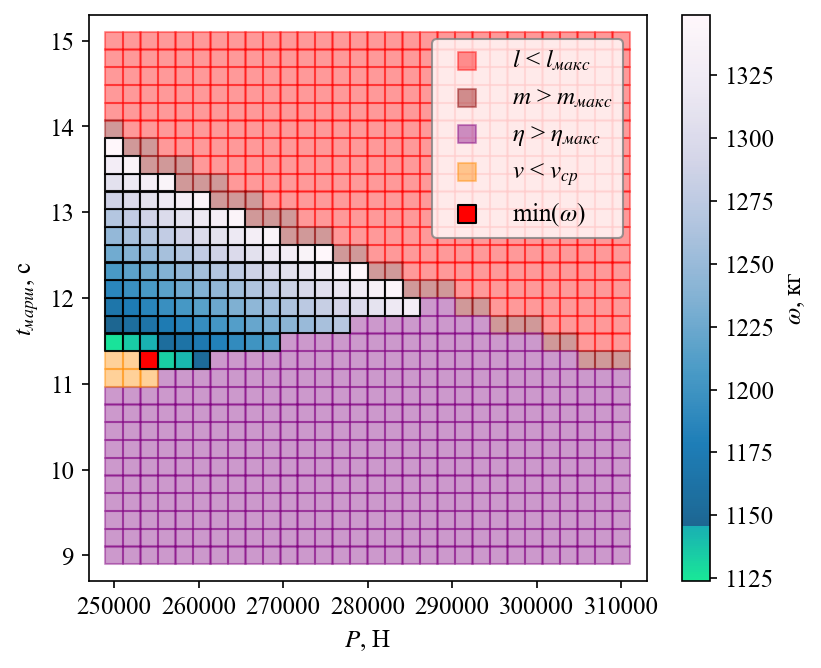

In [82]:
fontsize = 12
s = 70
alpha = 0.4
# -----------------------------------------
fig = plt.figure(figsize=(6,5), dpi=150)
# -----------------------------------------
plt.scatter(arr1_thrust, arr1_t_act,
            marker = 's',
            color = 'red',
            label = '$l$ < $l_{макс}$',
            s = s,
            alpha = alpha)
plt.scatter(arr2_thrust, arr2_t_act,
            marker = 's',
            color = 'darkred',
            label = '$m$ > $m_{макс}$',
            s = s,
            alpha = alpha)
plt.scatter(arr3_thrust, arr3_t_act,
            marker = 's',
            color = 'purple',
            label = r'$\eta$ > $\eta$$_{макс}$',
            s = s,
            alpha = alpha)
plt.scatter(arr4_thrust, arr4_t_act,
            marker = 's',
            color = 'darkorange',
            label = '$v$ < $v_{ср}$',
            s = s,
            alpha = alpha)
# -----------------------------------------
ax = plt.scatter(arr5_thrust, arr5_t_act, c=arr5_w,
                 cmap=newcmp,
                 edgecolor='k',
                 marker = 's',
                 s = s,
                 alpha = 0.9)
cb = plt.colorbar(ax)
cb.set_label('$\omega$, кг', fontsize=fontsize)
cb.ax.tick_params(labelsize=fontsize)
cb.ax.locator_params(nbins=10)
# -----------------------------------------
plt.scatter(thrust,
            t_act,
            marker = 's',
            color = 'r',
            edgecolor='k',
            label = 'min($\omega$)',
            s = s)
# -----------------------------------------
plt.tick_params(labelsize=fontsize)
plt.ylabel('$t_{марш}$, с', fontsize=fontsize)
plt.xlabel('$P$, Н', fontsize=fontsize)
plt.legend(loc=1,
           fontsize = 12,
           bbox_to_anchor=(.98, .98),
           edgecolor ='grey')
# -----------------------------------------
plt.savefig('pictures/Обратная_задача.png', dpi=300, bbox_inches='tight')
plt.show()